<a href="https://colab.research.google.com/github/YonggunJung/Project1-KOSPI/blob/main/kospi_LSTM_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil

# 경고 뜨지 않게..
import warnings
warnings.filterwarnings('ignore')

# 그래프 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = 20, 10
plt.rcParams['axes.unicode_minus'] = False

# 랜덤 모듈
import random

# 학습 모델 저장 및 복원
import pickle

# 딥러닝 라이브러리
import tensorflow as tf
# 신경망 모델을 관리하는 객체
from tensorflow.keras.models import Sequential
# 선형 회귀 레이어
from tensorflow.keras.layers import Dense
# 활성화 함수를 정의하는 객체
from tensorflow.keras.layers import Activation
# CNN : 커널을 통해 합성곱을 구하는 것, 이미지의 특징이 두드러지게 한다.
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv1D
# MaxPooling : 커널내에서 가장 큰 값을 추출하는 방식으로 불필요한 부분을 제거한다., 값이 작은부분은 빠져버린다
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import MaxPool1D
# Flatten : 다차원의 이미지 데이터를 선형회귀 은닉층으로 전달하기 전에
# 1차원으로 변환하는것
from tensorflow.keras.layers import Flatten
# Dropout : 이미지나 영상, 음파등의 데이터는 오랫동안 학습을 진행 시켜야 한다.
# 하지만 너무 빨리 과적합이 발생되면 조기 중단 때문에 학습 횟수가 줄어들 수 있다.
# 이에 은닉의 노드를 일부 사용하지 않으므로써 과적합이 빨리 오는것을 예방하고
# 오랫동안 학습이 진행될 수있도록한다
from tensorflow.keras.layers import Dropout
# Embedding : 단어의 수를 조정한다.
from tensorflow.keras.layers import Embedding

# LSTM
from tensorflow.keras.layers import LSTM


from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional



# 원핫 인코딩을 수행하는 함수
from tensorflow.keras.utils import to_categorical

# 저장된 학습 모델을 복원한다.
from tensorflow.keras.models import load_model

# 모델을 자동 저장한다.
from tensorflow.keras.callbacks import ModelCheckpoint

# 성능이 더이상 좋아지지 않을 경우 중단 시킨다.
from tensorflow.keras.callbacks import EarlyStopping

# 문장을 잘라준다.
from tensorflow.keras.preprocessing.text import Tokenizer
# 모든 문장 데이터의 단어 데이터의 수를 동일한 수로 맞춰준다.
from tensorflow.keras.preprocessing.sequence import pad_sequences
# 문자열을 가지고 단어 사전을 만들어준다.
from tensorflow.keras.preprocessing.text import text_to_word_sequence


# 평가함수
# 분류용
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# 회귀용
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# 표준화
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# 문자열 -> 숫자
from sklearn.preprocessing import LabelEncoder

# 전체데이터를 학습용과 검증으로 나눈다.
from sklearn.model_selection import train_test_split

# 랜덤시드 설정
# 데이터를 랜덤하게 섞거나 가중치를 랜덤하게 설정하는 등..
# 작업에서 랜덤을 적용하는 경우가 더러 있다.
# 이에, 시드를 고정시킨다.
random_seed = 1

np.random.seed(random_seed)
random.seed(random_seed)
tf.random.set_seed(random_seed)

# 현재 프로젝트에서 GPU 메모리 사용을 필요한 만큼만 쓸 수 있도록 한다.
# 컴퓨터에 있는 GPU 정보들을 가져온다.
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu가 있다면...
if len(gpus) > 0 :
    try :
        for gpu in gpus :
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e :
        print(e)

from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, Dropout
from tensorflow.keras import Input, Model
from tensorflow.keras import optimizers
import os

In [ ]:
# 데이터를 읽어온다.
cell = pd.read_csv('./data/코스피상관관계1 월별.csv')
cell

,Unnamed: 0,일자,코스피,코스피200,S&P500,금값,나스닥,넷플릭스,물가지수,상해종합,...,국고채(3년),"회사채(3년, AA-)",니케이,실업률,미국달러환율,중국위안환율,일본100엔환율,유로,WTI유가전처리,필라델피아반도체
0,0,2002-05-01,844.778182,105.976818,1067.14,326.55,1660.310913,1.135834,78.37,1577.194661,...,6.300,7.070,11709.623419,3.1,1266.06,0.00,1001.56,1160.82,25.31,476.3
1,1,2002-06-01,785.747222,98.738333,989.82,314.45,1505.488489,1.038071,77.87,1562.779449,...,5.930,6.760,10965.875977,2.9,1223.47,0.00,993.12,1169.42,26.86,387.6
2,2,2002-07-01,754.257619,94.774762,911.62,303.55,1346.085455,1.110000,77.65,1695.699330,...,5.700,6.590,10352.265243,3.0,1185.12,0.00,1003.88,1175.59,27.02,330.9
3,3,2002-08-01,712.824286,89.500476,916.07,312.75,1327.360463,0.870974,77.75,1660.573054,...,5.370,6.230,9751.204590,3.2,1196.37,0.00,1004.44,1170.00,28.98,300.2
4,4,2002-09-01,705.708000,88.293500,815.28,323.55,1251.069006,0.828071,77.91,1619.580707,...,5.370,6.060,9354.008429,2.7,1208.50,0.00,1001.56,1184.33,30.45,238.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,237,2022-02-01,2722.530000,364.624444,4373.79,1908.99,13898.728413,400.986317,114.95,3461.950607,...,2.285,2.873,27066.525391,3.4,1198.34,188.81,1039.85,1359.89,95.72,3429.5
238,238,2022-03-01,2699.054286,359.868571,4530.41,1937.43,13623.262950,366.791741,116.70,3284.306099,...,2.369,3.028,26584.077681,3.0,1221.03,192.16,1028.59,1345.33,100.28,3429.0
239,239,2022-04-01,2700.210000,356.095238,4131.93,1896.92,13394.163037,297.414499,118.59,3134.839741,...,2.941,3.631,27043.333691,3.0,1232.34,191.82,977.38,1334.08,104.69,2919.7
240,240,2022-05-01,2628.356190,347.516190,4132.15,1837.36,11829.729539,186.449524,119.43,3090.437898,...,3.019,3.775,26653.769531,3.0,1269.88,188.78,985.49,1342.43,114.67,3098.7


In [ ]:
cell.index = pd.to_datetime(cell['일자'], format = '%Y-%m-%d')

In [ ]:
# 불필요한 컬럼을 제거한다.
cell.drop([ 'Unnamed: 0', '일자'], axis=1, inplace=True)

In [ ]:
# 입력과 결과로 나눈다.
X = cell[['필라델피아반도체','S&P500','WTI유가전처리', '금값', '나스닥', '물가지수','상해종합','주택매매가격지수']]
y = cell['코스피']

display(X)
display(y)

,필라델피아반도체,S&P500,WTI유가전처리,금값,나스닥,물가지수,상해종합,주택매매가격지수
일자,,,,,,,,
2002-05-01,476.3,1067.14,25.31,326.55,1660.310913,78.37,1577.194661,46.910
2002-06-01,387.6,989.82,26.86,314.45,1505.488489,77.87,1562.779449,47.118
2002-07-01,330.9,911.62,27.02,303.55,1346.085455,77.65,1695.699330,47.574
2002-08-01,300.2,916.07,28.98,312.75,1327.360463,77.75,1660.573054,48.402
2002-09-01,238.2,815.28,30.45,323.55,1251.069006,77.91,1619.580707,49.563
...,...,...,...,...,...,...,...,...
2022-02-01,3429.5,4373.79,95.72,1908.99,13898.728413,114.95,3461.950607,100.207
2022-03-01,3429.0,4530.41,100.28,1937.43,13623.262950,116.70,3284.306099,100.306
2022-04-01,2919.7,4131.93,104.69,1896.92,13394.163037,118.59,3134.839741,100.517


일자
2002-05-01     844.778182
2002-06-01     785.747222
2002-07-01     754.257619
2002-08-01     712.824286
2002-09-01     705.708000
                 ...     
2022-02-01    2722.530000
2022-03-01    2699.054286
2022-04-01    2700.210000
2022-05-01    2628.356190
2022-06-01    2487.598500
Name: 코스피, Length: 242, dtype: float64

In [ ]:
# 표준화
scaler1 = StandardScaler()
X = scaler1.fit_transform(X)
X

array([[-0.47915588, -0.86481126, -1.67938176, ..., -2.00030778,
        -1.18363759, -1.79387355],
       [-0.58605773, -0.94566399, -1.61591814, ..., -2.05263325,
        -1.19982274, -1.77704617],
       [-0.65439296, -1.02743694, -1.60936705, ..., -2.07565646,
        -1.05058261, -1.74015537],
       ...,
       [ 2.46564655,  2.34000838,  1.57077454, ...,  2.20875345,
         0.56525921,  2.54297952],
       [ 2.68137858,  2.34023843,  1.97939837, ...,  2.29666024,
         0.5154056 ,  2.56328564],
       [ 2.02767438,  1.97762458,  1.63341928, ...,  2.36677638,
         0.7455201 ,  2.57145663]])

In [ ]:
scaler2 = MinMaxScaler()
y = scaler2.fit_transform(y.values.reshape(-1, 1))
y

array([[0.10796466],
       [0.08617146],
       [0.07454605],
       [0.05924958],
       [0.05662237],
       [0.03417463],
       [0.04646831],
       [0.05525208],
       [0.02986265],
       [0.01497046],
       [0.        ],
       [0.01171071],
       [0.02228408],
       [0.04066944],
       [0.05555735],
       [0.06591673],
       [0.0714114 ],
       [0.07446084],
       [0.08723591],
       [0.09212019],
       [0.10831872],
       [0.11603806],
       [0.11966858],
       [0.13129877],
       [0.09294873],
       [0.08190859],
       [0.07147549],
       [0.07941023],
       [0.10438096],
       [0.10983744],
       [0.11486703],
       [0.118237  ],
       [0.12867788],
       [0.15119031],
       [0.1620791 ],
       [0.14942804],
       [0.14275551],
       [0.16113149],
       [0.18625752],
       [0.20284558],
       [0.22733225],
       [0.23692172],
       [0.25762187],
       [0.28925858],
       [0.30646495],
       [0.29262288],
       [0.2880165 ],
       [0.317

In [ ]:
# # 2진 분류 옵션들
# out_nodes = 1
# loss_function = 'binary_crossentropy'
# activation_function = 'sigmoid'

# 다중 분류 옵션들
# out_nodes = len(y.value_counts())
# loss_function = 'categorical_crossentropy'
# activation_function = 'softmax'

# 회귀
# 출력 결과를 하나만 뽑아서 Series로 나왔다면...
# 1로 설정한다.
if type(y) is pd.core.series.Series :
    out_nodes = 1
else :
    out_nodes = y.shape[1]

# loss_function = 'mean_squared_error'

In [ ]:
# 입력노드의 개수
input_size = X.shape[1]
input_size

8

In [ ]:
# 시퀀스 데이터셋 구성
# 시퀀스 데이터 : 순서를 가지고 있는 데이터를 의미한다.
def windowed_dataset(series, window_size, batch_size, shuffle) :
    # 데이터의 차원을 1차원으로 조정한다.
    series = tf.expand_dims(series, axis=-1)
    # 데이터셋 객체를 생성한다.
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w : w.batch(window_size + 1))
    if shuffle == True :
        ds = ds.shuffle(1000)

    ds = ds.map(lambda w : (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)


In [ ]:
# 학습용과 검증용으로 나눈다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   random_state=1,
                                                   shuffle=False)

In [ ]:
X_train = X[:-100]
X_test = X[-100:]
y_train = y[:-100]
y_test = y[-100:]

In [ ]:
# 결과를 확인하기 위한 앞선 데이터의 수
WINDOW_SIZE = 20
# 데이터 배치 사이즈
BATCH_SIZE = 32

In [ ]:
# train_data는 학습용 데이터셋, test_data는 검증용 데이터 셋
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [ ]:
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
model = Sequential()
model.add(Conv1D(32, kernel_size=3,
           padding='causal',
           input_shape=[WINDOW_SIZE, 1]))
model.add(Activation('relu'))
model.add(LSTM(24, return_sequences=True))
model.add(Activation('relu'))
model.add(LSTM(10, return_sequences=False))
model.add(Activation('relu'))
model.add(RepeatVector(1))
model.add(LSTM(10, return_sequences=True))
model.add(Activation('relu'))
model.add(LSTM(24, return_sequences=True))
model.add(Activation('relu'))
model.add(TimeDistributed(Dense(1)))
model.add(Dense(10, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(1))

# create the autoencoder model
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 32)            128       
                                                                 
 activation (Activation)     (None, 20, 32)            0         
                                                                 
 lstm (LSTM)                 (None, 20, 24)            5472      
                                                                 
 activation_1 (Activation)   (None, 20, 24)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10)                1400      
                                                                 
 activation_2 (Activation)   (None, 10)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 1, 10)            0

In [ ]:
# 학습모델을 저장할 경로
path = './model/상관관계높은_LSTM_AE/'

# 만약 폴더가 있다면 삭제한다.
if os.path.isdir(path) :
    shutil.rmtree(path)

# 폴더를 생성한다.
os.makedirs(os.path.join(path))


In [ ]:
path1 = path + '/{epoch}-{val_loss}.h5'
path2 = path + '/best_model.h5'

# 저장콜백
call1 = ModelCheckpoint(filepath=path1, monitor='val_loss', save_best_only=True)
call2 = ModelCheckpoint(filepath=path2, monitor='val_loss', save_best_only=True)


In [ ]:
# 조기 중단
call3 = EarlyStopping(monitor='val_loss', patience=50)


In [ ]:
history = model.fit(train_data,
                   validation_data=(test_data),
                   epochs=1000000000,
                   callbacks=[call1, call2, call3])


Epoch 1/1000000000
4/4 [==============================] - 15s 914ms/step - loss: 0.3717 - val_loss: 0.6617
Epoch 2/1000000000
4/4 [==============================] - 1s 157ms/step - loss: 0.3648 - val_loss: 0.6546
Epoch 3/1000000000
4/4 [==============================] - 1s 145ms/step - loss: 0.3576 - val_loss: 0.6472
Epoch 4/1000000000
4/4 [==============================] - 0s 113ms/step - loss: 0.3501 - val_loss: 0.6396
Epoch 5/1000000000
4/4 [==============================] - 0s 97ms/step - loss: 0.3424 - val_loss: 0.6319
Epoch 6/1000000000
4/4 [==============================] - 0s 125ms/step - loss: 0.3346 - val_loss: 0.6238
Epoch 7/1000000000
4/4 [==============================] - 0s 97ms/step - loss: 0.3265 - val_loss: 0.6156
Epoch 8/1000000000
4/4 [==============================] - 0s 101ms/step - loss: 0.3182 - val_loss: 0.6071
Epoch 9/1000000000
4/4 [==============================] - 0s 101ms/step - loss: 0.3096 - val_loss: 0.5985
Epoch 10/1000000000
4/4 [======================

4/4 [==============================] - 0s 56ms/step - loss: 0.0447 - val_loss: 0.1341
Epoch 79/1000000000
4/4 [==============================] - 0s 59ms/step - loss: 0.0445 - val_loss: 0.1389
Epoch 80/1000000000
4/4 [==============================] - 0s 56ms/step - loss: 0.0436 - val_loss: 0.1303
Epoch 81/1000000000
4/4 [==============================] - 0s 58ms/step - loss: 0.0432 - val_loss: 0.1427
Epoch 82/1000000000
4/4 [==============================] - 0s 57ms/step - loss: 0.0427 - val_loss: 0.1346
Epoch 83/1000000000
4/4 [==============================] - 0s 54ms/step - loss: 0.0435 - val_loss: 0.1433
Epoch 84/1000000000
4/4 [==============================] - 0s 57ms/step - loss: 0.0432 - val_loss: 0.1369
Epoch 85/1000000000
4/4 [==============================] - 0s 54ms/step - loss: 0.0446 - val_loss: 0.1314
Epoch 86/1000000000
4/4 [==============================] - 0s 67ms/step - loss: 0.0431 - val_loss: 0.1381
Epoch 87/1000000000
4/4 [==============================] - 0s 53ms

Epoch 155/1000000000
4/4 [==============================] - 0s 63ms/step - loss: 0.0276 - val_loss: 0.1291
Epoch 156/1000000000
4/4 [==============================] - 0s 88ms/step - loss: 0.0277 - val_loss: 0.1268
Epoch 157/1000000000
4/4 [==============================] - 0s 53ms/step - loss: 0.0285 - val_loss: 0.1256
Epoch 158/1000000000
4/4 [==============================] - 0s 54ms/step - loss: 0.0279 - val_loss: 0.1294
Epoch 159/1000000000
4/4 [==============================] - 0s 66ms/step - loss: 0.0292 - val_loss: 0.1259
Epoch 160/1000000000
4/4 [==============================] - 0s 62ms/step - loss: 0.0269 - val_loss: 0.1307
Epoch 161/1000000000
4/4 [==============================] - 0s 52ms/step - loss: 0.0263 - val_loss: 0.1319
Epoch 162/1000000000
4/4 [==============================] - 0s 52ms/step - loss: 0.0275 - val_loss: 0.1204
Epoch 163/1000000000
4/4 [==============================] - 0s 56ms/step - loss: 0.0261 - val_loss: 0.1425
Epoch 164/1000000000
4/4 [===========

In [ ]:
# 리스트를 추출한다.
loss_list = history.history['loss']
val_loss_list = history.history['val_loss']


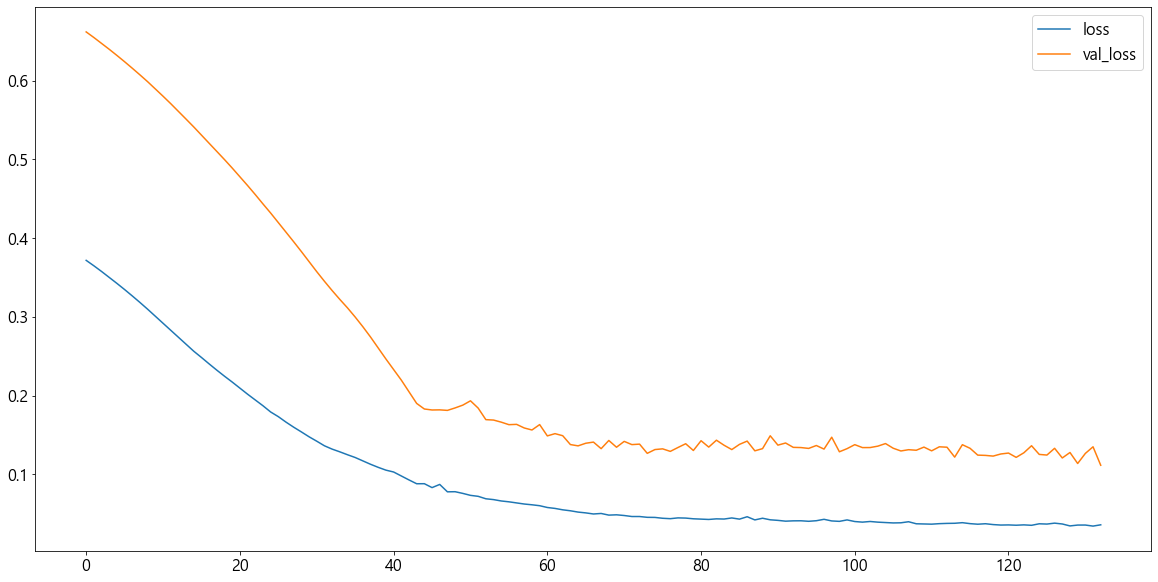

In [ ]:
# 손실률
plt.plot(loss_list[:-50], label='loss')
plt.plot(val_loss_list[:-50], label='val_loss')
plt.legend()
plt.show()

In [ ]:
# 모델을 가져온다.
best_model = load_model(path + '/best_model.h5')
best_model


In [ ]:
# 검증데이터를 통해 예측 결과를 가져온다.
pred = best_model.predict(test_data)
pred = pred.reshape(-1)
pred

3/3 [==============================] - 2s 36ms/step


array([0.54159313, 0.54018325, 0.5388818 , 0.5361705 , 0.5325915 ,
       0.530314  , 0.5296633 , 0.52977175, 0.5305309 , 0.5319408 ,
       0.5341099 , 0.53682125, 0.5394241 , 0.54061705, 0.54137623,
       0.5421354 , 0.5438707 , 0.5467989 , 0.5507032 , 0.5553667 ,
       0.55905414, 0.5633922 , 0.56686276, 0.57011634, 0.5729361 ,
       0.5757559 , 0.577708  , 0.5794433 , 0.58031094, 0.58074474,
       0.58074474, 0.58074474, 0.58031094, 0.5792264 , 0.57792497,
       0.5766235 , 0.5742375 , 0.57163465, 0.568598  , 0.566212  ,
       0.5653444 , 0.5646937 , 0.5657782 , 0.5653444 , 0.5642598 ,
       0.5627415 , 0.5581865 , 0.5544991 , 0.5518962 , 0.5515709 ,
       0.5531976 , 0.5566681 , 0.55970484, 0.5548244 , 0.54755807,
       0.5404002 , 0.5382311 , 0.5414847 , 0.55005246, 0.5594879 ,
       0.5651275 , 0.56989944, 0.5751052 , 0.5829138 , 0.59072244,
       0.5967958 , 0.60178465, 0.6052551 , 0.6080749 , 0.6100271 ,
       0.6111116 , 0.61154544, 0.6106778 , 0.6100271 , 0.60894

In [ ]:
# 원래 결과를 1차원으로 변환한다.
y_test2 = y_test.reshape(-1)
# 20일치를 가지고 21일째를 예측하기 떄문에
# 앞선 20일은 예측하지 않는다.
y_test2 = y_test2[20:]
y_test2

array([0.53776591, 0.52464621, 0.4957617 , 0.49783339, 0.52625303,
       0.5332808 , 0.52258171, 0.52653924, 0.53548049, 0.5480254 ,
       0.54944316, 0.54834197, 0.52905613, 0.5420493 , 0.55717374,
       0.56529502, 0.58409437, 0.5932654 , 0.64431977, 0.67155169,
       0.68747295, 0.67244261, 0.67153217, 0.71184693, 0.7332552 ,
       0.70874291, 0.72656829, 0.69915254, 0.70089889, 0.70331985,
       0.70733857, 0.6814881 , 0.64106427, 0.63889902, 0.6473999 ,
       0.59456622, 0.56420264, 0.56030878, 0.57088133, 0.61278426,
       0.59519992, 0.61232693, 0.56796891, 0.57205889, 0.56561109,
       0.51404241, 0.54959433, 0.56014399, 0.58253175, 0.58781239,
       0.61107587, 0.59579799, 0.45850467, 0.47696016, 0.52097277,
       0.58425161, 0.60741267, 0.66544484, 0.67290905, 0.6674512 ,
       0.71776807, 0.8100354 , 0.93595911, 0.93857071, 0.91551979,
       0.96411176, 0.96576683, 0.99823766, 1.        , 0.97259475,
       0.95709065, 0.90433932, 0.89430673, 0.89729593, 0.85905

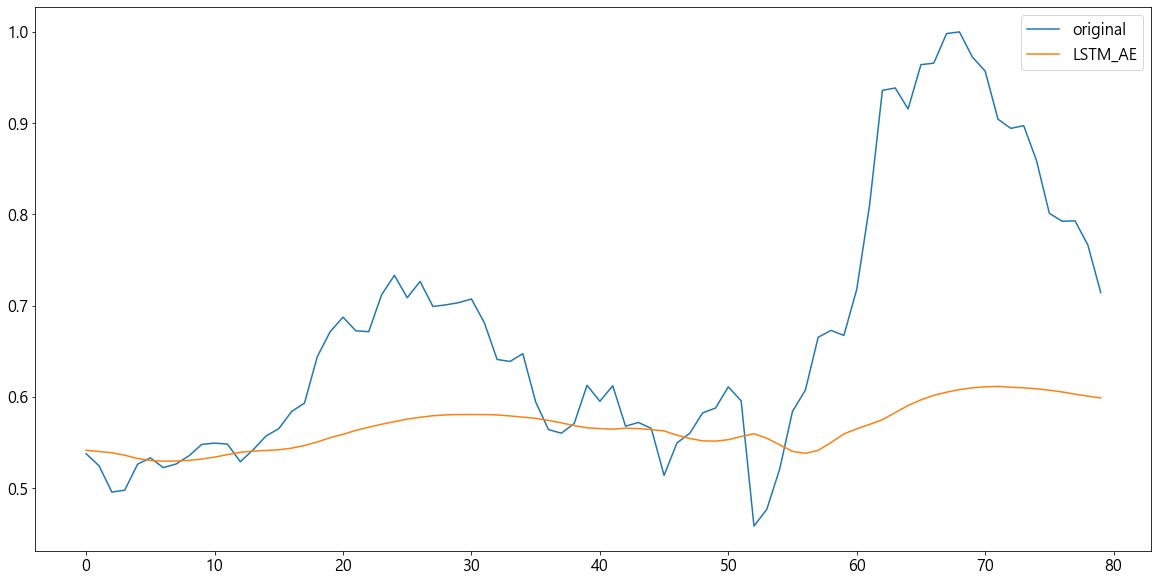

In [ ]:
# 양방향 LSTM
plt.plot(y_test2, label = 'original')
plt.plot(pred, label='LSTM_AE')
plt.legend()
plt.show()